In [20]:
# Install required packages if not already installed
# !pip install timm

In [21]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


import timm

In [23]:
class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['image']
        label = self.dataframe.iloc[idx]['label']

        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

def prepare_data(data_dir, batch_size=32):
    """
    Prepare data loaders for Chest X-ray dataset
    Assumes directory structure:
    data_dir/
        train/
            class1/
            class2/
        val/
            class1/
            class2/
        test/
            class1/
            class2/
    """

    # Data transforms
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Load datasets
    train_dataset = datasets.ImageFolder(
        root=os.path.join(data_dir, 'train'),
        transform=train_transform
    )

    val_dataset = datasets.ImageFolder(
        root=os.path.join(data_dir, 'val'),
        transform=val_transform
    )

    test_dataset = datasets.ImageFolder(
        root=os.path.join(data_dir, 'test'),
        transform=val_transform
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                             shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader, train_dataset.classes

In [24]:
class ViTForChestXRay(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(ViTForChestXRay, self).__init__()

        # Load pretrained ViT model
        self.vit = timm.create_model('vit_base_patch16_224',
                                   pretrained=pretrained,
                                   num_classes=0)  # Remove classification head

        # Get feature dimension
        self.feature_dim = self.vit.num_features

        # Custom classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Extract features from ViT
        features = self.vit(x)

        # Classification
        output = self.classifier(features)

        return output

def create_model(num_classes=2, device='cuda'):
    """Create and initialize the ViT model"""
    model = ViTForChestXRay(num_classes=num_classes)
    model = model.to(device)
    return model

In [25]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device), target.to(self.device)

            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc

    def validate_epoch(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in self.val_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = self.criterion(output, target)

                running_loss += loss.item()
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()

        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc

    def train(self, epochs):
        print("Starting training...")

        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate_epoch()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accs.append(train_acc)
            self.val_accs.append(val_acc)

            print(f'Epoch: {epoch+1:02d}/{epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print('-' * 50)
        return self.train_losses, self.train_accs, self.val_accs

    def plot_training_history(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss plot
        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Val Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # Accuracy plot
        ax2.plot(self.train_accs, label='Train Acc')
        ax2.plot(self.val_accs, label='Val Acc')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()

        plt.tight_layout()
        plt.show()

In [26]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Classification report
    print("Classification Report:")
    print(classification_report(all_targets, all_predictions,
                              target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()



    return all_predictions, all_targets

def predict_single_image(model, image_path, transform, device, class_names):
    """Predict a single chest X-ray image"""
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    # Display results
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Predicted: {class_names[predicted.item()]}\n'
              f'Confidence: {confidence.item():.2f}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.bar(class_names, probabilities.cpu().numpy()[0])
    plt.title('Class Probabilities')
    plt.xticks(rotation=45)
    plt.ylabel('Probability')

    plt.tight_layout()
    plt.show()

    return class_names[predicted.item()], confidence.item()

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Classes: ['NORMAL', 'PNEUMONIA']
Training samples: 5216
Validation samples: 16
Test samples: 624
Starting training...
Epoch: 01/7
Train Loss: 0.2049, Train Acc: 90.99%
Val Loss: 0.3039, Val Acc: 81.25%
--------------------------------------------------
Epoch: 02/7
Train Loss: 0.1494, Train Acc: 94.06%
Val Loss: 0.8908, Val Acc: 75.00%
--------------------------------------------------
Epoch: 03/7
Train Loss: 0.1354, Train Acc: 94.59%
Val Loss: 0.1586, Val Acc: 93.75%
--------------------------------------------------
Epoch: 04/7
Train Loss: 0.1163, Train Acc: 95.55%
Val Loss: 0.1403, Val Acc: 93.75%
--------------------------------------------------
Epoch: 05/7
Train Loss: 0.1053, Train Acc: 96.11%
Val Loss: 0.3145, Val Acc: 87.50%
--------------------------------------------------
Epoch: 06/7
Train Loss: 0.1136, Train Acc: 95.76%
Val Loss: 0.4980, Val Acc: 75.00%
--------------------------------------------------
Epoch: 07/7
Train Loss: 0.1023, Train Acc: 95.97%
Val Loss: 0.1734, Val 

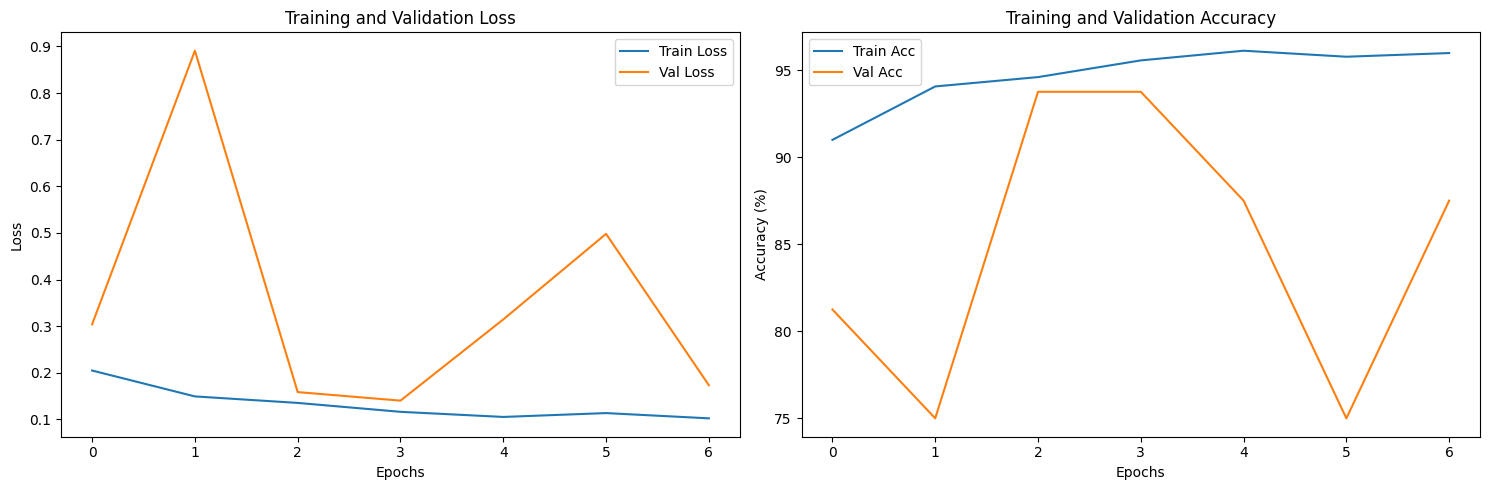

In [27]:
# ============================================================
#   CONFIGURATION
# ============================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/"
batch_size = 32
num_epochs = 7
learning_rate = 1e-3
num_classes = 2  # NORMAL (0), PNEUMONIA (1)

# ============================================================
#   DATA
# ============================================================
train_loader, val_loader, test_loader, class_names = prepare_data(
    data_dir, batch_size
)

print(f"Classes: {class_names}")
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

# ============================================================
#   MODEL (ViT)
# ============================================================
model = create_model(num_classes=num_classes, device=device)

# -------- OPTIONAL BUT HIGHLY RECOMMENDED --------
# Freeze ViT encoder
for param in model.vit.parameters():
    param.requires_grad = False

# Unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True


# -------------------------------------------------

model.to(device)

# ============================================================
#   LOSS + OPTIMIZER + SCHEDULER (Same as VGG19)
# ============================================================
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
    weight_decay=1e-4
)


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',     # لأننا هنعتمد على validation accuracy
    factor=0.5,
    patience=1
)

# ============================================================
#   TRAINING
# ============================================================
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, device)

train_losses, train_accuracies, val_accuracies = trainer.train(num_epochs)

# Call scheduler with validation accuracy from last epoch
scheduler.step(val_accuracies[-1])

# ============================================================
#   PLOT TRAINING HISTORY
# ============================================================
trainer.plot_training_history()


In [28]:
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(model, test_loader, device, class_names):
    model.eval()
    all_targets = []
    all_scores = []

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)

            output = model(data)  # logits shape: [B, 2]
            probs = torch.softmax(output, dim=1)[:, 1]  # score for class 'PNEUMONIA'

            all_scores.extend(probs.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    all_scores = np.array(all_scores)
    all_targets = np.array(all_targets)

    # Compute ROC
    fpr, tpr, _ = roc_curve(all_targets, all_scores)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()



Evaluating on test set...
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.71      0.81       234
   PNEUMONIA       0.85      0.97      0.91       390

    accuracy                           0.87       624
   macro avg       0.89      0.84      0.86       624
weighted avg       0.88      0.87      0.87       624



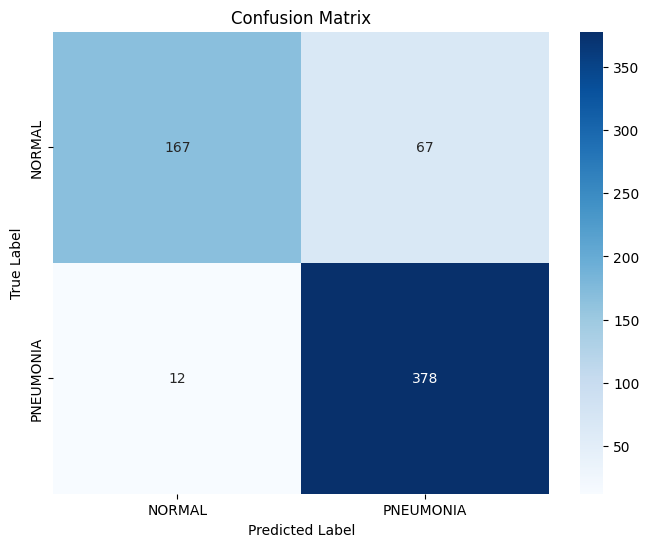

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


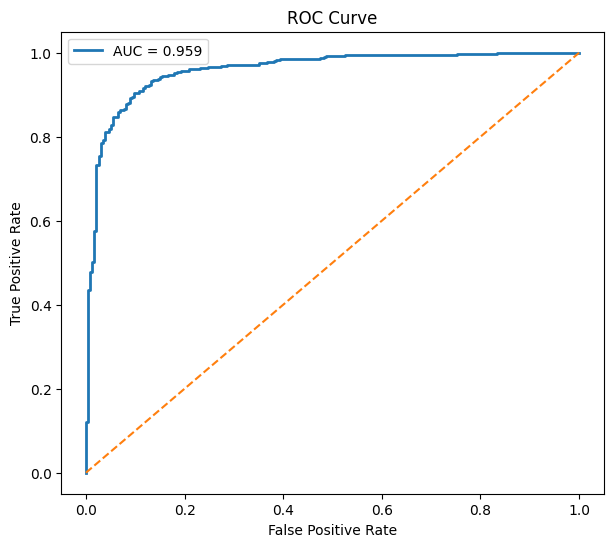

Model saved successfully!


In [29]:
# Evaluate on test set
print("\nEvaluating on test set...")
predictions, targets = evaluate_model(model, test_loader, device, class_names)

# Plot ROC curves and AUC
plot_roc_auc(model, test_loader, device, class_names)

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_names': class_names
}, 'vit_chest_xray.pth')

print("Model saved successfully!")


In [30]:
#load the saved model
model1 = torch.load('vit_chest_xray.pth')

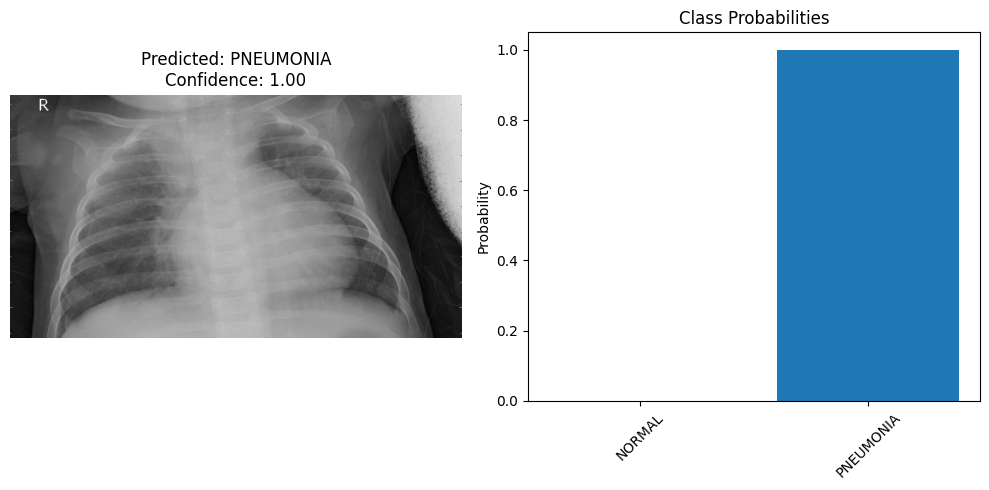

Predicted class: PNEUMONIA, Confidence: 1.00


In [31]:
import random

# Assuming device, val_transform are defined from previous cells or execution context.
# If not, ensure they are defined before this cell runs.

# Configuration from main() function
num_classes = 2 # Based on the training in main()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/" # Ensure this path is correct

# Redefine val_transform and test_dataset if they are not in the global scope
val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

test_dataset = datasets.ImageFolder(
        root=os.path.join(data_dir, 'test'),
        transform=val_transform
    )

# Recreate the model structure
model = ViTForChestXRay(num_classes=num_classes) # Instantiate the model

# Load the state dictionary into the model
model.load_state_dict(model1['model_state_dict'])
model = model.to(device)
model.eval() # Set model to evaluation mode

# Get class names from the loaded dictionary
class_names = model1['class_names']

# Select a random image from the test_dataset
random_idx = random.randint(0, len(test_dataset) - 1)
image_path_to_predict = test_dataset.samples[random_idx][0] # Get the file path of the image

# Predict the single image
predicted_class, confidence = predict_single_image(model, image_path_to_predict, val_transform, device, class_names)

print(f"Predicted class: {predicted_class}, Confidence: {confidence:.2f}")